In [1]:
from google.colab import drive

In [2]:
# Importando as bibliotecas necessárias.
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score , f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

In [3]:
# Lendo os dados da tabela
df = pd.read_csv('/content/drive/MyDrive/tcc/base_de_dados_tcc_tratada_v2.csv', low_memory=False)
df.head()

,League,Home,Away,INC,Round,Date,Temporada,Time,H_Score,A_Score,...,A_Offsides,H_Throw_in,A_Throw_in,H_Goalkeeper_Saves,A_Goalkeeper_Saves,H_Fouls,A_Fouls,H_Yellow_Cards,A_Yellow_Cards,Game Link
0,premier-league,Chelsea,Everton,"[""09' Goal_Home - Mata J."", ""14' Goal_Away - N...",38,5/19/2013,12-13,17:00,2,1,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2.0,2.0,https://www.flashscore.com/match/CSiF8w91/#/ma...
1,premier-league,Liverpool,QPR,"[""08' Yellow_Home - Henderson J."", ""23' Goal_H...",38,5/19/2013,12-13,17:00,1,0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,3.0,https://www.flashscore.com/match/jJjJ7cO7/#/ma...
2,premier-league,Manchester City,Norwich,"[""26' Goal_Away - Pilkington A."", ""29' Goal_Ho...",38,5/19/2013,12-13,17:00,2,3,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0,https://www.flashscore.com/match/Szz2Wt18/#/ma...
3,premier-league,Newcastle,Arsenal,"[""23' Yellow_Home - Gutierrez J."", ""39' Yellow...",38,5/19/2013,12-13,17:00,0,1,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,2.0,https://www.flashscore.com/match/6RY5V0GE/#/ma...
4,premier-league,Southampton,Stoke,"[""05' Yellow_Away - Whitehead D."", ""28' Yellow...",38,5/19/2013,12-13,17:00,1,1,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,2.0,https://www.flashscore.com/match/bNdZDYps/#/ma...


In [4]:
df = df[df['League'] == 'serie-a']

# Display the filtered DataFrame
len(df)

3798

In [5]:
# Criando a coluna com o identificador do jogo (ID_PARTIDA)

df = pd.DataFrame(df)
df = df.reset_index()
df = df.rename(columns = {"index": "ID_PARTIDA"})
df["ID_PARTIDA"] = df.index + 1

In [6]:
def calcular_dupla_hipotese(odds_empate, odds_fora):
    # Calcular as probabilidades implícitas
    prob_empate = 1 / odds_empate
    prob_fora = 1 / odds_fora

    # Calcular a probabilidade combinada
    prob_fora_ou_empate = prob_empate + prob_fora - (prob_empate * prob_fora)

    # Converter a probabilidade combinada em odds
    odds_fora_ou_empate = 1 / prob_fora_ou_empate

    return odds_fora_ou_empate

In [7]:
df['DRAW_OR_AWAY'] = None

for i in range(len(df)):
    empate = df.loc[i, "X_BET"]
    fora = df.loc[i, "A_BET"]

    df.loc[i, 'DRAW_OR_AWAY'] = calcular_dupla_hipotese(empate, fora)

df.DRAW_OR_AWAY.head()

,DRAW_OR_AWAY
0,1.731818
1,1.409756
2,1.562162
3,1.780488
4,1.154617


In [8]:
# Alterando os resultados de string (Draw = empate, Home = vitória do time da casa, Away = vitória do time visitante), para
# inteiro (0 = empate, 1 = vitória do time da casa, 2 = vitória do time visitante)
for i in range(0,len(df)):
    if df["WIN"][i] == "Home":
        df.at[i,"WIN"] = '0'
    if df["WIN"][i] == "Draw":
        df.at[i,"WIN"] = '1'
    if df["WIN"][i] == "Away":
        df.at[i,"WIN"] = '1'

df["WIN"] = df["WIN"].astype(str).astype(int)


Total de jogos:  3798
Total de colunas:  59
Total de jogos ganhos em casa:  1661
Total de jogos ganhos pelo visitante:  2137
Percentual de jogos ganhos em casa: 43.73%


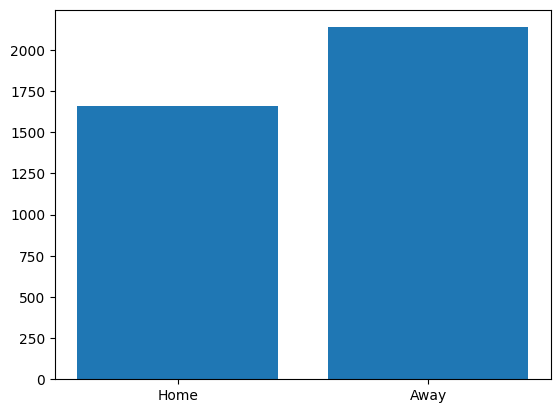

In [9]:
# Capturando a quantidade de partidas e colunas da base
matches = df.shape[0]
features = df.shape[1]

# Separando as vitórias do time da casa, visitante e empate
home_win = len(df[df.WIN==0])
away_win = len(df[df.WIN==1])
val = [home_win, away_win]

# Percentual de vitórias do time da casa
win_rate = (float(home_win)/(matches)) *100

# Mostrando na tela os resultados em texto e gráfico
print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))
x = np.arange(2)
plt.bar(x, val)
plt.xticks(x, ('Home', 'Away'))
plt.show()

In [10]:
features = df[['H_BET', 'DRAW_OR_AWAY']]
labels = df['WIN']


print('Features')
print(features.head())
print('=====================')
print('Labels')
print(labels.head())

scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ',features_scale.shape)
print(features_scale)

# Separação de treino e teste
# Treino [:3038]     representa 80% dos dados
# Teste [3038:3418]      representa 10% dos dados
# Previsão [3038:3418]     representa 10% dos dados

X_train = features_scale[:3038]
X_test = features_scale[3038:3418]
y_train = labels[:3038]
y_test = labels[3038:3418]
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

Features
   H_BET DRAW_OR_AWAY
0   2.40     1.731818
1   4.37     1.409756
2   3.04     1.562162
3   2.29     1.780488
4   9.13     1.154617
Labels
0    0
1    0
2    1
3    1
4    1
Name: WIN, dtype: int64
Features:  (3798, 2)
[[0.06766917 0.05123866]
 [0.16641604 0.02412159]
 [0.09974937 0.03695392]
 ...
 [0.21303258 0.02547625]
 [0.01453634 0.22201943]
 [0.07869674 0.0600764 ]]
3038 3038
380 380


In [12]:
# Rodando o modelo de Regressão Logística em sua versão multinomial

clf_LR = LogisticRegression(multi_class = 'multinomial', max_iter = 2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lr_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Regressão Logística')
print('')
print('Acurácia: {:.2f}%'.format(lr_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Regressão Logística

Acurácia: 71.58%
F1 Score: 69.37%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [17]:
# Rodando o modelo de Árvore de Decisão

clf_DT = DecisionTreeClassifier(random_state=42)
clf_DT.fit(X_train, y_train)
pred = clf_DT.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Árvore de Decisão')
print('')
print('Acurácia: {:.2f}%'.format(dt_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Árvore de Decisão

Acurácia: 64.74%
F1 Score: 63.19%


In [19]:
# Inicializando o classificador de Rede Neural
clf_NN = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000, random_state=42)

# Treinando o modelo
clf_NN.fit(X_train, y_train)

# Fazendo previsões
pred_nn = clf_NN.predict(X_test)

# Calculando Acurácia e F1-Score
nn_acc = accuracy_score(y_test, pred_nn)
f1_nn = f1_score(y_test, pred_nn, average='macro')

# Exibindo os resultados
print('Rede Neural')
print('')
print('Acurácia: {:.2f}%'.format(nn_acc * 100))
print('F1 Score: {:.2f}%'.format(f1_nn * 100))

Rede Neural

Acurácia: 71.32%
F1 Score: 69.40%


In [20]:
# Rodando o modelo de Naive Bayes

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
pred = clf_NB.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average = 'macro')

print('Naive Bayes')
print('')
print('Acurácia Naive Bayes: {:.2f}%'.format(nb_acc*100))
print('F1 Score: {:.2f}%'.format(f1*100))

Naive Bayes

Acurácia Naive Bayes: 71.84%
F1 Score: 70.57%


In [ ]:
previsao = features_scale[2746:]

game_id_full = df['ID_PARTIDA']
game_id_prev = game_id_full[2746:]

res_full = df['WIN']
res_prev = res_full[2746:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'Real': res_prev, 'Previsão': pred, 'ID_PARTIDA': game_id_prev})

print(df)

      Real  Previsão  ID_PARTIDA
2746     1         1        2747
2747     0         0        2748
2748     0         0        2749
2749     1         0        2750
2750     0         1        2751
...    ...       ...         ...
3793     1         1        3794
3794     1         1        3795
3795     1         1        3796
3796     0         0        3797
3797     1         1        3798

[1052 rows x 3 columns]


<Axes: xlabel='Previsão', ylabel='Real'>

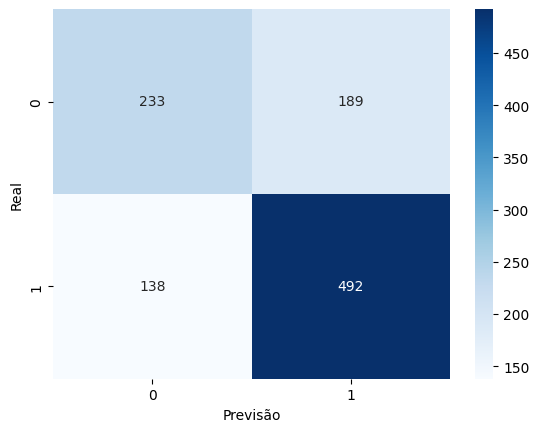

In [ ]:
#confusion Matrix

df = pd.DataFrame(df,columns = ['Real','Previsão'])

cf_matrix = pd.crosstab(df['Real'], df['Previsão'], rownames = ['Real'] , colnames = ['Previsão'])

sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')